In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from TileEM_plot_toolbox import *
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA_DIR="output"
os.chdir(DATA_DIR)

# Problem: The tiles are not exactly non-overalpping 

## Debugging BB2TileExact 

In [4]:
def overlap(a,b):
    if a.area>b.area:
        larger_area = a.area
    else:
        larger_area = b.area
    return a.intersection(b).area/larger_area

In [126]:
def compute_unique_tileset(tiles,PLOT=True):
    duplicate_count = 0
    verified_tiles = []
    duplicated=False
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    if PLOT:
                        plt.figure()
                        plt.title("[{0},{1}]{2}".format(tidx,vtidx, overlap_score))
                        plot_coords(vt)
                        plot_coords(t,color="blue")
                    duplicated=True
                    if vt.area>t.area:
                        verified_tiles.remove(vt)
                        new_vt = vt.difference(t)
                        verified_tiles.append(new_vt)
                        verified_tiles.append(t)
                    else:
                        verified_tiles.remove(t)
                        new_t = t.difference(vt)
                        verified_tiles.append(new_t)
                        verified_tiles.append(vt)
                    duplicate_count+=1
                    
            except(shapely.geos.TopologicalError):

                print "Topological Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    return  duplicated, verified_tiles

In [8]:
def compute_verfied_tiles_duplication_rate(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    print "Duplication rate: ", duplicate_count/float(len(tiles))
    return verified_tiles

In [6]:
def slow_cascaded_union(tiles):
    all_tiles  = copy.deepcopy(tiles)
    Utile=tiles[0]
    all_tiles.remove(tiles[0])
    i=1
    loss_tiles = []
    while(len(all_tiles)>0):
        tile = tiles[i]
        try:
            Utile = Utile.union(tile)
        except(shapely.geos.TopologicalError):
            try:
                Utile =Utile.buffer(0).union(tile.buffer(0))
            except(shapely.geos.TopologicalError):
#                 return tile,Utile 
                #print "Throwing away:", tile.area 
                loss_tiles.append(tile)
        all_tiles.remove(tile)
        i+=1
    try:
        Utile=Utile.union(cascaded_union(loss_tiles))
    except(shapely.geos.TopologicalError):
        try:
            Utile=Utile.buffer(9e-13).union(cascaded_union(loss_tiles).buffer(0))
        except(shapely.geos.TopologicalError):
            loss_area = sum([t.area for t in loss_tiles])
            print "Throwing away:", loss_area
    return loss_tiles,Utile

In [7]:
def visualizeTilesSeparate(tiles,colorful=True):
    plt.figure()
    colors=cm.rainbow(np.linspace(0,1,len(tiles)))
    for t,i in zip(tiles,range(len(tiles))): 
#         plt.figure()
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True,fill_color=c)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True,fill_color=c)

In [9]:
def createObjIndicatorMatrix(objid,tiles="",load_existing_tiles_from_file=False, PLOT=False,sampleNworkers=-1,random_state=111,PRINT=False,SAVE=False,EXCLUDE_BBG=True,overlap_threshold=0.8,tile_only=False,tqdm_on=False):

    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects = bb_info[bb_info["object_id"]==objid]
    if EXCLUDE_BBG: bb_objects =  bb_objects[bb_objects.worker_id!=3]
    # Sampling Data from Ji table 
    if sampleNworkers>0 and sampleNworkers<len(bb_objects):
        bb_objects = bb_objects.sample(n=sampleNworkers,random_state=random_state)
    # Create a list of polygons based on worker BBs 
    xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    BB = []
    for xyloc in xylocs:
        BB.append(Polygon(xyloc).buffer(0))

    #Compute Tiles 
    if load_existing_tiles_from_file:
        tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
        #worker_lst= pkl.load(open("{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    elif tiles=="":
        tiles = BB2TileExact(objid,BB,tqdm_on=tqdm_on,save_tiles=SAVE)
    if tile_only:
    	if PLOT: visualizeTiles(tiles)
    	return tiles,0
    # Convert set of tiles to indicator matrix for all workers and tiles
    # by checking if the worker's BB contains the tile pieces
    # The indicator matrix is a (N + 1) X M matrix, 
    # with first N rows indicator vectors for each annotator and
    # the last row being region sizes
    worker_lst = list(bb_objects.worker_id)
    M = len(tiles)
    N = len(worker_lst)
    if PRINT: 
        print "Number of non-overlapping tile regions (M) : ",M
        print "Number of workers (N) : ",N
    indicator_matrix = np.zeros((N+1,M))

    for  wi in range(N):
        worker_id = worker_lst[wi]
        worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
        worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]]))).buffer(0)

        # Check if worker's polygon contains this tile
        for tile_i in range(M):
            tile = tiles[tile_i]
            if worker_BB_polygon.contains(tile.centroid):
                indicator_matrix[wi][tile_i]=1
            else:
            	try:
            		tileBB_overlap = tile.intersection(worker_BB_polygon).area/float(tile.area)
            		if tileBB_overlap>=overlap_threshold:
            			indicator_matrix[wi][tile_i]=1
            	except(shapely.errors.TopologicalError):
            		pass

    # The last row of the indicator matrix is the tile area
    for tile_i in range(M):
        tile=tiles[tile_i]
        indicator_matrix[-1][tile_i]=tile.area
    # Debug plotting all tiles that have not been voted by workers 
    all_unvoted_tiles=np.where(np.sum(indicator_matrix[:-1],axis=0)==0)[0]
    if PRINT:
        print "all unvoted tiles:",all_unvoted_tiles
        print "all unvoted workers:",np.where(np.sum(indicator_matrix,axis=1)==0)[0]
    if PLOT or PRINT:
        print "Object ",objid
        sanity_check(indicator_matrix,PLOT)
    if SAVE:
    	pkl.dump(worker_lst,open('../{0}/worker{1}.pkl'.format(DATA_DIR,objid),'w'))
    	pkl.dump(indicator_matrix,open('../{0}/indMat{1}.pkl'.format(DATA_DIR,objid),'w'))
    return worker_lst,tiles,indicator_matrix

In [10]:
# verified_tiles = compute_verfied_tiles_duplication_rate(tiles)

In [11]:
def visualizeTiles(tiles,colorful=True):
    plt.figure()
    colormap = plt.cm.Paired
    colors = [colormap(i) for i in np.linspace(0, 1,len(tiles))]
    for t,i in zip(tiles,range(len(tiles))): 
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True)

------------------------------Adding BB0------------------------------
------------------------------Adding BB1------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting:  4
Finished leftovers starting:  7
------------------------------Adding BB2------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 30%|███       | 3/10 [00:00<00:00,  8.96it/s]

 29
Finished leftovers starting:  39
------------------------------Adding BB3------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------
Bi-(Bi intersect Uorig_tiles)
Adding leftovers starting: 

 67
Finished leftovers starting:  70
------------------------------Adding BB4------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.052 248.345, 536.739 253.071) and LINESTRING (535.052 248.345, 538.045 256.727) at 535.24490154631417 248.8857243296795



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (519.692 334.692, 530.182 334.273) and LINESTRING (530.182 334.273, 525.676 334.453) at 529.39189382046516 334.3043242471814
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 246, 527.207 242.276) and LINESTRING (538.045 256.727, 527.207 242.276) at 527.2068965517243 242.27586206896567


 38
First toplological error, tile 45
First toplological error, tile 55
Adding leftovers starting: 

 105
Finished leftovers starting:  113
------------------------------Adding BB5------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (386.815 260.579, 386.815 260.579) and LINESTRING (385.538 257.038, 386.815 260.579) at 386.81523500810374 260.578606158833



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.822 280.257, 532.97 283.876) and LINESTRING (532.97 283.876, 538.352 286.268) at 532.97041420118342 283.87573964497039


 114
First toplological error, tile 153
Adding leftovers starting: 

 60%|██████    | 6/10 [00:11<00:07,  0.52it/s]

 177
Finished leftovers starting:  177
------------------------------Adding BB6------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533 282, 535.844 274.281) and LINESTRING (535.84 274.288, 535.844 274.281) at 535.84374999999989 274.28125000000028



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (558.061 296.515, 563.548 304.355) and LINESTRING (562 309, 563.548 304.355) at 563.54838709677415 304.35483870967744


 198
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.14 278.907) and LINESTRING (534.776 276.204, 534.14 278.907) at 534.52119820558312 277.28490762627132


 209
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.14 278.907, 534.14 278.907) and LINESTRING (534.14 278.907, 534.14 278.907) at 534.13953488372101 278.90697674418578


 225
First toplological error, tile 226
Adding leftovers starting:  230
Finished leftovers starting: 

 89%|████████▉ | 210/236 [00:05<00:00, 37.79it/s]

 236
Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685
BAD: BB, continuing but remove duplicates

 6
------------------------------Adding BB7------------------------------
----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.455 297, 559.4 291.4) and LINESTRING (560.017 292.53, 559.4 291.4) at 559.54372182793361 291.66349001787842



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (559 290.667, 553 286) and LINESTRING (559 290.667, 557 287) at 559 290.66666666666657
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (565 306, 564.032 301.806) and LINESTRING (564.032 301.806, 564.135 302.784) at 564.0322580645161 301.80645161290323
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (540.66 258.617, 535.348 249.174) and LINESTRING (535.348 249.174, 537.765 255.941) at 535.3478260869565 249.17391304347831


 28
First toplological error, tile 29
First toplological error, tile 30
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 46
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 135
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385 247.895, 385.438 247.434) and LINESTRING (385 247.895, 385.438 247.434) at 385.43603571076608 247.43575188340412


 135
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 136
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 136
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 137
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 137
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 138
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 138
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 139
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 139
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 140
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 140
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 141
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 141
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 142
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 142
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 143
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 143
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 144
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 144
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 145
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 145
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 146
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 146
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 147
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 147
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 148
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 148
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 149
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 149
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 150
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 150
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 151
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 151
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 152
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 152
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 153
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 153
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 154
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 154
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 155
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 156
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 156
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 157
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 157
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 159
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 159
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 160
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 160
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 161
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 161
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 162
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 162
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 163
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 163
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 164
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 164
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 165
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 165
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 166
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 166
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 167
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 167
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 168
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 168
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 169
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 169
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 170
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 170
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 171
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 171
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 172
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 172
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 173
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 173
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 174
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 174
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 175
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 175
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 176
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 176
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 177
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (423.413 331.815, 435.241 337.966) and LINESTRING (429.667 337.222, 435.241 337.966) at 435.2413793103571 337.96551724138095


 177
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 178
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 178
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 179
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 179
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 180
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 180
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 181
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (388 282, 393.068 295.254) and LINESTRING (392.413 293.54, 392.743 295.486) at 392.41253263707574 293.54046997389048


 181
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 182
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 182
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 183
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (419.524 329.793, 423.413 331.815) and LINESTRING (419.524 329.793, 425.968 335.065) at 419.52439024389128 329.79268292682013


 183
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 184
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 184
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 185
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 185
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 186
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 186
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 187
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 187
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 188
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 188
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 189
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 189
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 190
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 190
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 191
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 191
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 192
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 192
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 193
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 193
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 194
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 194
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 195
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 195
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 196
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 196
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 197
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 197
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 198
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 198
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 199
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 199
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 200
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 200
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 201
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 201
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 202
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 202
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 203
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 203
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 204
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 204
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 205
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 205
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 206
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 206
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 207
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 207
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 208
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 208
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 209
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 209
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 210
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 210
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 211
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 211
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 212
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 212
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 213
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 213
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 214
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 214
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 215
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 215
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 216
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 216
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 217
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 217
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 218
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 218
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 219
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (499.553 230.404, 499.553 230.404) and LINESTRING (499.553 230.404, 493 229) at 499.55319148957011 230.40425531919357


 219
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 220
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (499.5 230.375, 500 230.5) and LINESTRING (500 230.5, 500 230.5) at 499.99999999999903 230.49999999999977


 220
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 221
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 221
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 222
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 222
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 223
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 223
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 224
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 224
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 225
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 225
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 226
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 226
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 227
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 227
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 228
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 228
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 229
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (388 282, 392.413 293.54) and LINESTRING (392.413 293.54, 386.815 260.579) at 392.41253263707563 293.54046997389008


 229
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 230
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 230
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 231
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 231
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 232
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 232
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 233
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 233
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 234
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 234
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 235
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 235
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 236
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 236
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 237
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 237
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 238
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 238
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 239
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 239
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 240
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 240
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 241
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 241
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 242
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 242
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 243
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 243
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 244
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 244
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 245
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 245
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 246
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 246
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 247
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 247
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 248
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 248
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 249
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 249
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 250
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 250
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 251
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 251
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 252
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 252
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 253
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 253
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 254
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 254
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 255
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 255
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 256
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 256
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 257
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 257
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 258
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 258
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 259
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 259
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 260
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 260
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 261
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 261
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 262
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 262
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 263
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.254 245.493, 384.191 245.125) and LINESTRING (384.191 245.125, 384.254 245.493) at 384.19112331738313 245.125503980145


 263
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 264
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 264
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 265
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.195 235.057, 393.383 236.277) and LINESTRING (397.195 235.057, 393.383 236.277) at 393.3836422911308 236.27723446683831


 265
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 266
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 266
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 267
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 267
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 268
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 268
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 269
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 269
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 270
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 270
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 271
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 271
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 272
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 272
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 273
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 273
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 274
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 274
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 275
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 275
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 276
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (496.727 229.234, 497.31 229.345) and LINESTRING (497.31 229.345, 496.727 229.234) at 497.30945959532625 229.34465897053832


 276
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 277
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 277
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 278
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 278
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 279
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 279
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 280
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 280
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 281
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 281
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 282
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 282
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 283
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 283
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 284
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 284
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 285
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 285
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 286
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 286
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 287
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 287
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 288
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 288
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 289
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 289
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 290
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (448 340, 446.645 339.486) and LINESTRING (447.749 339.633, 446.645 339.486) at 446.64485981315426 339.48598130842055


 290
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 291
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 291
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 292
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 292
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 293
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 293
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 294
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 294
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 295
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 295
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 296
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 296
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 297
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 297
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 298
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 298
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 299
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 299
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 300
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 300
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 301
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 301
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 302
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 302
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 303
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 303
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 304
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 304
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 305
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 305
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 306
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 306
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 307
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 307
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 308
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 308
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 309
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 309
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 310
Throw out later : Topological error #67, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


 310
diffing tile# 0
diffing tile# 1
diffing tile# 2
diffing tile# 3
diffing tile# 4
diffing tile# 5
diffing tile# 6
diffing tile# 7
diffing tile# 8
diffing tile# 9
diffing tile# 10
diffing tile# 11
diffing tile# 12
diffing tile# 13
diffing tile# 14
diffing tile# 15
diffing tile# 16
diffing tile# 17
diffing tile# 18
diffing tile# 19
diffing tile# 20
diffing tile# 21
diffing tile# 22
diffing tile# 23
diffing tile# 24
diffing tile# 25
diffing tile# 26
diffing tile# 27
diffing tile# 28
diffing tile# 29
diffing tile# 30
diffing tile# 31
diffing tile# 32
diffing tile# 33
diffing tile# 34
diffing tile# 35
diffing tile# 36
diffing tile# 37
diffing tile# 38
diffing tile# 39
diffing tile# 40
diffing tile# 41
diffing tile# 42
diffing tile# 43
diffing tile# 44
diffing tile# 45
diffing tile# 46
diffing tile# 47
diffing tile#

ERROR:shapely.geos:TopologyException: side location conflict at 534.1395348837209 278.90697674418618


 48
diffing tile# 49
diffing tile# 50
diffing tile# 51
diffing tile# 52
diffing tile# 53
diffing tile# 54
diffing tile# 55
diffing tile# 56
diffing tile# 57
diffing tile# 58
diffing tile# 59
diffing tile# 60
diffing tile# 61
diffing tile# 62
diffing tile# 63
diffing tile# 64
diffing tile# 65
diffing tile# 66
diffing tile# 67
diffing tile# 68
diffing tile# 69
diffing tile# 70
diffing tile# 71
diffing tile# 72
diffing tile# 73
diffing tile# 74
diffing tile# 75
diffing tile# 76
diffing tile# 77
diffing tile# 78
diffing tile# 79
diffing tile# 80
diffing tile# 81
diffing tile# 82
diffing tile# 83
diffing tile# 84
diffing tile# 85
diffing tile# 86
diffing tile# 87
diffing tile# 88
diffing tile# 89
diffing tile# 90
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (456.312 343.039, 458.256 343.282) and LINESTRING (458.256 343.282, 448 340) at 458.25641025599981 343.282051282
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (456.312 343.039, 458.256 343.282) and LINESTRING (458.256 343.282, 448 340) at 458.25641025599981 343.282051282


 91
diffing tile# 92
diffing tile# 93
diffing tile# 94
diffing tile# 95
diffing tile# 96
diffing tile# 97
diffing tile# 98
diffing tile# 99
diffing tile# 100
diffing tile# 101
diffing tile# 102
diffing tile# 103
diffing tile# 104
diffing tile# 105
diffing tile# 106
diffing tile# 107
diffing tile# 108
diffing tile# 109
diffing tile# 110
diffing tile# 111
diffing tile# 112
diffing tile# 113
diffing tile# 114
diffing tile# 115
diffing tile# 116
diffing tile# 117
diffing tile# 118
diffing tile# 119
diffing tile# 120
diffing tile# 121
diffing tile# 122
diffing tile# 123
diffing tile# 124
diffing tile# 125
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.254 245.493, 384.254 245.493) and LINESTRING (384.254 245.493, 384.254 245.493) at 384.25352112684192 245.49295774631639


 126
diffing tile# 127
diffing tile# 128
diffing tile# 129
diffing tile# 130
diffing tile# 131
diffing tile# 132
diffing tile# 133
diffing tile# 134
diffing tile# 135
diffing tile# 136
diffing tile# 137
diffing tile# 138
diffing tile# 139
diffing tile# 140
diffing tile# 141
diffing tile# 142
diffing tile# 143
diffing tile# 144
diffing tile# 145
diffing tile# 146
diffing tile# 147
diffing tile# 148
diffing tile# 149
diffing tile# 150
diffing tile# 151
diffing tile# 152
diffing tile# 153
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (446.645 339.486, 446.645 339.486) and LINESTRING (446.645 339.486, 446.645 339.486) at 446.64485981462593 339.48598130861683


 154
diffing tile# 155
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.182 243.636, 386.134 242.604) and LINESTRING (386.889 242.111, 386.134 242.604) at 386.13432835820896 242.6044776119403


 156
diffing tile# 157
diffing tile# 158
diffing tile# 159
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (389 240, 390.081 238.379) and LINESTRING (390.2 238.2, 389 240) at 390.08097928436922 238.37853107344614


 160
diffing tile# 161
diffing tile# 162
diffing tile# 163
diffing tile#

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.091 282.697, 535.651 280.829) and LINESTRING (535.044 282.681, 537 283.333) at 535.09090909091287 282.69696969697094


 164
diffing tile# 165
diffing tile# 166
diffing tile# 167
diffing tile# 168
diffing tile# 169
diffing tile# 170
diffing tile# 171
diffing tile# 172
diffing tile#

 173
Adding leftovers starting:  311
Finished leftovers starting:  311
------------------------------Adding BB8------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (563.829 303.388, 563.842 303.474) and LINESTRING (563.842 303.474, 563.133 298.867) at 563.84210526315792 303.47368421052624



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (496 229, 496.727 229.234) and LINESTRING (488.652 227.696, 496.727 229.234) at 496.7272727272719 229.23376623376606


 113
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.444 249.444, 536.555 252.553) and LINESTRING (536.587 252.645, 535.444 249.444) at 536.54716256521203 252.53205518259395


 189
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (500.87 230.565, 501.581 230.839) and LINESTRING (502 230.929, 498.406 229.773) at 500.86956521739114 230.56521739130429


 200
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (500 230.5, 500 230.5) and LINESTRING (500 230.5, 500 230.5) at 499.99999999999903 230.4999999999998


 202
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.182 243.636, 386.134 242.604) and LINESTRING (386.889 242.111, 385.486 243.029) at 386.13432835820896 242.6044776119403


 208
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.482 277.451) and LINESTRING (534.14 278.907, 534.776 276.204) at 534.68578346171387 276.58542028771586


 216
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.605 332.553, 539.348 332.696) and LINESTRING (540.556 332.333, 539.605 332.553) at 539.6052631578948 332.55263157894734


 226
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (426.795 335.638, 426.5 335.5) and LINESTRING (425.968 335.065, 426.5 335.5) at 426.50000000000011 335.50000000000006


 231
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (462.146 341.553, 466.05 342.073) and LINESTRING (467.266 342.235, 462.146 341.553) at 464.73320845854118 341.8977611278055


 237
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (402.312 313.532, 402.783 314.222) and LINESTRING (402.818 314.273, 402.312 313.532) at 402.50194052097669 313.81052845373517


 245
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (563.857 305.286, 563.904 304.863) and LINESTRING (563.904 304.863, 563 313) at 563.87712777006425 305.10585006942239


 281
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.565 276.583, 534.194 277.252) and LINESTRING (534.19 277.257, 535.844 274.281) at 534.22249862294279 277.19950247870275


 286
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.851 277.868, 533.321 278.821) and LINESTRING (533.321 278.821, 533.321 278.821) at 533.32142857142856 278.82142857142867


 290
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.4 275, 537.889 272.556) and LINESTRING (537.889 272.556, 537.4 275) at 537.67932521562659 273.6033739218671


 292
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 426.62913907284769 335.4503311258278


 303
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (435.698 338.203, 435.241 337.966) and LINESTRING (446.645 339.486, 435.241 337.966) at 435.24137931034488 337.9655172413793


 307
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.321 278.821, 533.94 277.708) and LINESTRING (533.321 278.821, 534.776 276.204) at 533.53260940949383 278.44130306291123


 308
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (463 221, 452.581 222.226) and LINESTRING (452.581 222.226, 458 222) at 452.58064516129053 222.2258064516129


 315
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (526.304 241.072, 527 242) and LINESTRING (527 242, 526.27 241.027) at 526.45974445367767 241.27965927157018


 318
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 537.765 255.941) and LINESTRING (537.765 255.941, 537.765 255.941) at 537.76470588235281 255.94117647058735


 330
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 537.765 255.941) and LINESTRING (537.765 255.941, 537.765 255.941) at 537.76470588235281 255.94117647058738


 333
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.023 305.597, 398.038 308.253) and LINESTRING (397.388 306.336, 397.2 306.062) at 397.20000000000005 306.06153846153853


 335
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (465.667 344.333, 465.667 344.333) and LINESTRING (469 344, 465.667 344.333) at 465.6666666666676 344.33333333333326


 354
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (495.436 228.475, 496.663 228.947) and LINESTRING (492.12 227.2, 496.663 228.947) at 496.15794532782706 228.75305589531811


 367
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (424 225, 433 223.65) and LINESTRING (433 223.65, 426 224) at 432.99999999999994 223.65000000000001


 370
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 421.64705882352951 225.35294117647058


 371
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (492.12 227.2, 486.759 225.711) and LINESTRING (486.759 225.711, 492.12 227.2) at 489.4395180722891 226.45542168674697


 372
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 537.105 255.474) and LINESTRING (536.263 254.35, 534.77 252.36) at 536.04472486857878 254.05963315810504


 376
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (508.222 231.889, 503.73 230.568) and LINESTRING (503.73 230.568, 498.075 229.491) at 503.72972972972968 230.56756756756758


 386
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 392.99999999999989 234.36363636363643


 388
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (545 329.333, 540.011 330.996) and LINESTRING (539.919 331.027, 540.614 330.795) at 540.48927261796484 330.836909127345


 394
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (390.623 237.742, 390.2 238.2) and LINESTRING (390.2 238.2, 390.963 237.056) at 390.20000000000016 238.19999999999973


 396
First toplological error, tile 402
Adding leftovers starting: 

 90%|█████████ | 9/10 [02:12<00:14,  0.07it/s]

 406
Finished leftovers starting:  406
------------------------------Adding BB9------------------------------


----------- All tiles before leftover calculation is non-overlapping ---------------

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.095 251.266, 536.095 251.266) and LINESTRING (536.095 251.266, 535.052 248.345) at 536.09493670886104 251.26582278481098



Bi-(Bi intersect Uorig_tiles)
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.182 243.636, 385.182 243.636) and LINESTRING (385.182 243.636, 385.182 243.636) at 385.1818181818187 243.63636363636311


 162
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.776 276.204, 534.482 277.451) and LINESTRING (534.14 278.907, 534.776 276.204) at 534.68578346171387 276.58542028771586


 173
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (436.195 223.171, 416.5 227.348) and LINESTRING (424.667 226.111, 416.5 227.348) at 416.50000000000892 227.348484848483


 180
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.253 334.11, 525.953 334.442) and LINESTRING (530.182 334.273, 528 335) at 530.18181818181813 334.27272727272731


 181
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (533.851 277.868, 533.321 278.821) and LINESTRING (533.321 278.821, 533.321 278.821) at 533.32142857142856 278.82142857142867


 214
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 426.62913907284769 335.4503311258278


 229
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (435.698 338.203, 435.241 337.966) and LINESTRING (446.645 339.486, 435.241 337.966) at 435.24137931034488 337.9655172413793


 239
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.889 272.556, 537.889 272.556) and LINESTRING (537.889 272.556, 537.889 272.556) at 537.88888888888891 272.55555555555537


 240
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 524.45901639344288 334.86885245901641


 246
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (504.878 231.854, 504.878 231.854) and LINESTRING (502.747 231.089, 504.878 231.854) at 504.8780487804874 231.85365853658521


 316
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.665 282.585, 387.442 282.105) and LINESTRING (387.665 282.585, 384.788 261.874) at 387.66463414634148 282.58536585365852


 318
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (550.961 324.792, 547.742 327.065) and LINESTRING (551.025 323.417, 547.742 327.065) at 547.74193548387109 327.06451612903214


 329
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 458.25641025641022 343.28205128205127


 331
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.895 256.526, 537.105 255.474) and LINESTRING (537.105 255.474, 538.006 256.675) at 537.32456140350882 255.76608187134499


 339
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.39 249.661, 528.8 244.4) and LINESTRING (534.39 249.661, 531.571 248.095) at 534.3898305084731 249.66101694915173


 344
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (559.222 306.389, 560 313) and LINESTRING (559.222 306.389, 561.4 310.2) at 559.22222222222229 306.3888888888892


 345
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (557.818 317.364, 557 319) and LINESTRING (557 319, 562.176 313.824) at 557.00000000000011 318.99999999999983


 352
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.442 282.105, 390.833 289.41) and LINESTRING (390.833 289.41, 388 282) at 390.83333333333314 289.4102564102559


 361
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.095 251.266, 528.8 244.4) and LINESTRING (528.8 244.4, 530.901 247.201) at 528.80000000000098 244.40000000000134


 383
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (528.8 244.4, 528.112 243.753) and LINESTRING (528.112 243.753, 528.112 243.753) at 528.11235955056122 243.75280898876372


 390
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (528.8 244.4, 528.8 244.4) and LINESTRING (528.8 244.4, 529.271 245.029) at 528.80000000000098 244.40000000000126


 391
First toplological error, tile

ERROR:shapely.geos:TopologyException: no outgoing dirEdge found at 412.41665339823868 228.21464927916148


 395
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.093 315.331, 562.093 315.331) and LINESTRING (562.093 315.331, 562.093 315.331) at 562.09271523178813 315.3311258278145


 405
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.093 315.331, 562.093 315.331) and LINESTRING (562.093 315.331, 562.093 315.331) at 562.09271523178813 315.3311258278145


 418
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (433.639 338.831, 434.25 339) and LINESTRING (433.639 338.831, 434.25 339) at 434.12756930499773 338.9662260151718


 420
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (524 335, 517.189 336.946) and LINESTRING (515.632 336.842, 517.189 336.946) at 517.18918918918916 336.94594594594594


 421
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (534.565 276.583, 534.194 277.252) and LINESTRING (534.19 277.257, 535.844 274.281) at 534.22249862294279 277.19950247870275


 426
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.629 264.02, 538.784 259.838) and LINESTRING (538.617 259.404, 538.784 259.838) at 538.78378378378375 259.83783783783787


 436
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.868 262.658, 538.784 259.838) and LINESTRING (539 260.4, 539 262) at 539 260.40000000000015


 437
First toplological error, tile

ERROR:shapely.geos:TopologyException: side location conflict at 536.83333333333337 272.5


 439
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.4 275, 537.511 274.446) and LINESTRING (537.4 275, 537.653 273.735) at 537.47704162029561 274.61479189852207


 442
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.889 272.556, 537.757 273.811) and LINESTRING (538 273, 537.739 273.869) at 537.75675675675677 273.81081081081066


 446
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.25 274.25, 539 269) and LINESTRING (538.267 273.794, 538.25 274.25) at 538.25 274.24999999999994


 448
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.773 273.137, 538.071 271.646) and LINESTRING (538.409 269.955, 537.889 272.556) at 537.89230701622705 272.53846491886446


 449
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.095 251.266, 536.095 251.266) and LINESTRING (536.095 251.266, 536.095 251.266) at 536.09493670886104 251.26582278481095


 453
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.893 252.017, 537.765 255.941) and LINESTRING (536.893 252.017, 537.765 255.941) at 537.64019366119373 255.38087147537169


 462
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (434.153 338.973, 434.25 339) and LINESTRING (433.516 338.774, 434.25 339) at 434.24999999999989 339


 463
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (438.637 340.21, 440.599 340.751) and LINESTRING (440.599 340.751, 439.341 340.098) at 440.59887005649699 340.75141242937843


 476
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (492.665 227.47, 491.741 227.138) and LINESTRING (491.211 226.947, 492.112 227.271) at 492.10954963350326 227.27009474023194


 477
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (491.211 226.947, 491.211 226.947) and LINESTRING (491.211 226.947, 491.211 226.947) at 491.21052631578959 226.94736842105266


 483
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (496.663 228.947, 495 228.308) and LINESTRING (495 228.308, 496.663 228.947) at 495.49945442875492 228.4997901649057


 485
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.195 243.872, 384.879 243.037) and LINESTRING (384.195 243.872, 385 243.346) at 384.19548872180451 243.87218045112778


 490
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.895 256.526, 537.105 255.474) and LINESTRING (537.105 255.474, 537.895 256.526) at 537.2185827386262 255.62477698483488


 497
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.895 256.526, 537.105 255.474) and LINESTRING (537.105 255.474, 538.006 256.675) at 537.32456140350882 255.76608187134499


 499
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (502.747 231.089, 498.543 229.58) and LINESTRING (498.543 229.58, 498.075 229.491) at 498.54347826086962 229.57971014492756


 501
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (436.195 223.171, 434.224 223.589) and LINESTRING (434.224 223.589, 443.273 223.136) at 434.22429906542055 223.58878504672899


 502
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (449.066 223.262, 455.633 223.405) and LINESTRING (453 223, 455.633 223.405) at 455.63291139240499 223.40506329113924


 506
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (480.945 339.655, 480.945 339.655) and LINESTRING (480.945 339.655, 480.945 339.655) at 480.94545454545431 339.65454545454548


 507
First toplological error, tile

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (546.269 328.104, 546.269 328.104) and LINESTRING (546.269 328.104, 546.269 328.104) at 546.26865671641781 328.10447761194035


 512
First toplological error, tile 515
Adding leftovers starting: 

 73%|███████▎  | 377/519 [00:17<00:06, 21.90it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015


 519
Finished leftovers starting:  519
Topological Error

 395 297


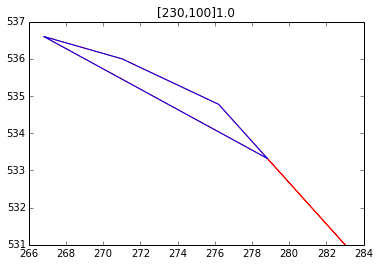

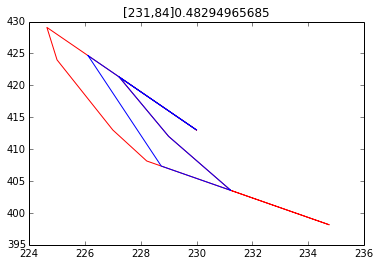

In [140]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
###################################
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    print "------------------------------Adding BB"+str(i)+"------------------------------"
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:

            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        xj_lst.append(xj)
                    else:
                        xj_lst.append(tj)
            except(shapely.errors.TopologicalError):
                print "xj list last item ignored"
                xj_lst=xj_lst[:-1]
                pass

        duplicated,uniquify_tiles = compute_unique_tileset(tiles)
        
        if duplicated:
            print "before leftover BAD: BB,continue",i
            #tiles = uniquify_tiles
            break 
        else:
            print "----------- All tiles before leftover calculation is non-overlapping ---------------"
                  

        print "Bi-(Bi intersect Uorig_tiles)"
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
        leftovers = bi
        throw_out_later = []
        for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
            try:
                leftovers = leftovers.difference(t) 
            except(shapely.geos.TopologicalError):
                print "First toplological error, tile",tidx
                try:
                    leftovers = leftovers.difference(t.buffer(-1e-10))
                except(shapely.geos.TopologicalError):
                    print "Throw out later : Topological error #67, tile",tidx
                    throw_out_later.append(t)              
#             if i==4:
#                 uniquify_tiles = compute_unique_tileset(tiles)
#                 boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#                 if not boolean_uniquify_tiles:
#                     print "doing leftover BAD: BB,continue, tile",tidx
#                     tiles = uniquify_tiles
#                     break 

        for tidx,tile in  enumerate(throw_out_later):
            print "diffing tile#",tidx
            try:
                leftovers = leftovers.difference(tile) 
            except(shapely.geos.TopologicalError):
                try:
                    leftovers = leftovers.difference(tile.buffer(1e-10))
                except(shapely.geos.TopologicalError):
                    leftovers = leftovers.buffer(1e-50).difference(tile)
#                 try:
                    
#                 except(shapely.geos.TopologicalError):
#                     leftovers = leftovers.buffer(1e-10).difference(tile.buffer(1e-10))
        tiles =copy.deepcopy(tiles_tmp)

        print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    #uniqufy check !!
    duplicated,uniquify_tiles = compute_unique_tileset(tiles)
    #boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    if duplicated:
        print "BAD: BB, continuing but remove duplicates",i
        tiles = uniquify_tiles
        #return tiles
#         break
#     if i ==6:
#         break 

# if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

In [ ]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
###################################
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    print "------------------------------Adding BB"+str(i)+"------------------------------"
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:

            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        xj_lst.append(xj)
                    else:
                        xj_lst.append(tj)
            except(shapely.errors.TopologicalError):
                print "xj list last item ignored"
                xj_lst=xj_lst[:-1]
                pass

        duplicated,uniquify_tiles = compute_unique_tileset(tiles)
        
        if duplicated:
            print "before leftover BAD: BB,continue",i
            #tiles = uniquify_tiles
            break 
        else:
            print "----------- All tiles before leftover calculation is non-overlapping ---------------"
                  

        print "Bi-(Bi intersect Uorig_tiles)"
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles))) # causes 2 duplicate tiles
        #leftovers = bi.difference(bi.intersection(cascaded_union(tiles_tmp)))
        leftovers = bi
        throw_out_later = []
        for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
            try:
                leftovers = leftovers.difference(t) 
            except(shapely.geos.TopologicalError):
                print "First toplological error, tile",tidx
                try:
                    leftovers = leftovers.difference(t.buffer(-1e-10))
                except(shapely.geos.TopologicalError):
                    print "Throw out later : Topological error #67, tile",tidx
                    throw_out_later.append(t)              
#             if i==4:
#                 uniquify_tiles = compute_unique_tileset(tiles)
#                 boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#                 if not boolean_uniquify_tiles:
#                     print "doing leftover BAD: BB,continue, tile",tidx
#                     tiles = uniquify_tiles
#                     break 

        for tidx,tile in  enumerate(throw_out_later):
            print "diffing tile#",tidx
            try:
                leftovers = leftovers.difference(tile) 
            except(shapely.geos.TopologicalError):
                try:
                    leftovers = leftovers.difference(tile.buffer(1e-10))
                except(shapely.geos.TopologicalError):
                    leftovers = leftovers.buffer(1e-50).difference(tile)
#                 try:
                    
#                 except(shapely.geos.TopologicalError):
#                     leftovers = leftovers.buffer(1e-10).difference(tile.buffer(1e-10))
        tiles =copy.deepcopy(tiles_tmp)

        print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    #uniqufy check !!
#     duplicated,uniquify_tiles = compute_unique_tileset(tiles)
#     #boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
#     if duplicated:
#         print "BAD: BB, continuing but remove duplicates",i
#         tiles = uniquify_tiles
        #return tiles
#         break
#     if i ==6:
#         break 

# if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

 92%|█████████▏| 216/236 [00:05<00:00, 39.56it/s]

Duplicate tiles:  230 100 1.0
Duplicate tiles: 

 231 84 0.48294965685


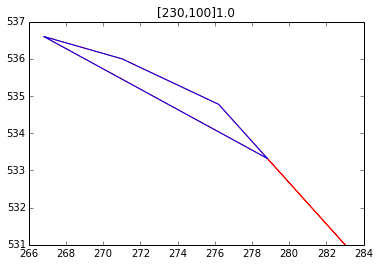

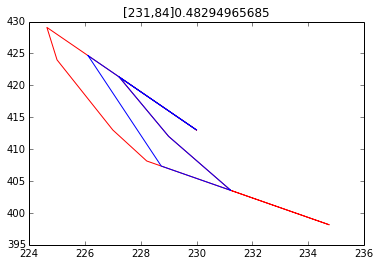

In [137]:
duplicated,verified_tiles = compute_unique_tileset(tiles)

In [139]:
duplicated,verified_tiles2 =compute_unique_tileset(verified_tiles)

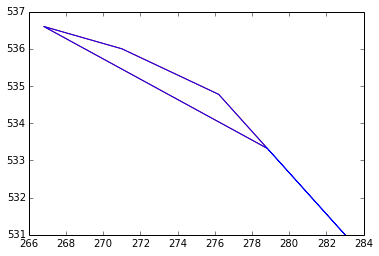

In [89]:
plot_coords(tiles[101])
plot_coords(tiles[36],color="blue")

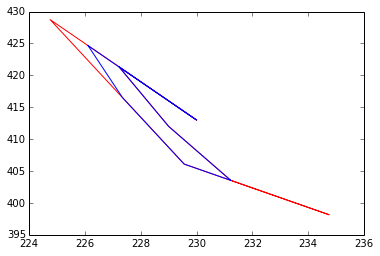

In [86]:
plot_coords(tiles[381])
plot_coords(tiles[412],color='blue')

In [113]:
compute_unique_tileset(tiles)

 73%|███████▎  | 390/532 [00:17<00:06, 21.67it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015


Duplicate tiles:  101 36 1.0
Topological Error 402 301
Duplicate tiles: 

 98%|█████████▊| 520/532 [00:32<00:00, 16.09it/s]

 412 381 0.822388219911
Duplicate tiles:  530 342 0.980785296569


ValueError: list.remove(x): x not in list

In [80]:
compute_verfied_tiles_duplication_rate(tiles)

 74%|███████▎  | 392/532 [00:18<00:06, 21.09it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (531.571 248.095, 528.452 243.935) and LINESTRING (528.8 244.4, 528.8 244.4) at 528.80000000000018 244.40000000000015


Duplicate tiles:  101 36 1.0
Error 402 301
Duplicate tiles: 

 95%|█████████▍| 504/532 [00:31<00:01, 16.01it/s]

 412 381 0.822388219911
Duplicate tiles: 

 530 342 0.980785296569
Duplication rate:  0.00563909774436


In [78]:
leftovers

1247.509176468278

In [69]:
leftovers.area

1254.5398685503408

In [75]:
leftovers.buffer(1e-50).area

1251.0533683874687

In [73]:
leftovers.buffer(1e-50).difference(tile).area

1247.509176468278

In [60]:
leftovers.difference(tile)

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (536.619 266.73, 536.611 266.759) and LINESTRING (536.601 266.796, 538.617 259.404) at 536.61121779966879 266.75886806788151


TopologicalError: This operation could not be performed. Reason: unknown

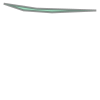

In [56]:
tiles[198]

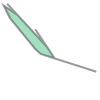

In [52]:
tiles[533]

In [50]:
tiles[536].difference(tiles[536].buffer(-1e-10)).area

9.550076285336218e-10

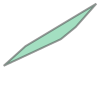

In [48]:
tiles[536].buffer(-1e-10)

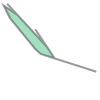

In [46]:
tiles[533]

In [ ]:
tiles[84]= tiles[84].difference(tiles[232])

In [22]:
tile = tiles[1]
tile.is_closed

False

In [25]:
tile.is_valid

True

In [26]:
tiles[84].is_valid

True

In [29]:
tile = tiles[232]

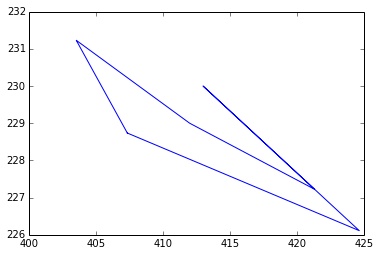

In [36]:
plt.plot(tile.boundary.xy[0],tile.boundary.xy[1])

In [42]:
from shapely.validation import explain_validity
tile = tiles[232].buffer(-1e-10)
explain_validity(tile)

'Valid Geometry'

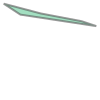

In [43]:
tile

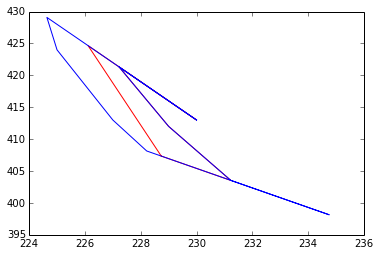

In [16]:
plot_coords(tiles[232])
plot_coords(tiles[84],color="blue")

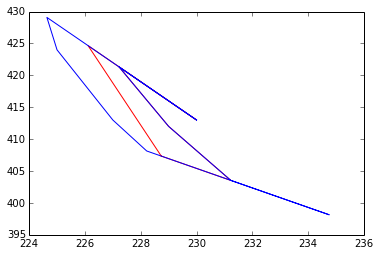

In [70]:
plot_coords(tiles[232])
plot_coords(tiles[84],color="blue")

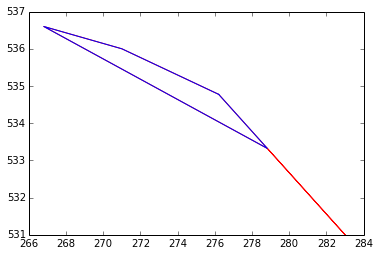

In [69]:
plot_coords(tiles[100])
plot_coords(tiles[229],color="blue")

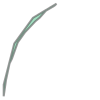

In [62]:
tiles[229]

In [38]:
throw_out_later[0].area

2.993761038547241

--------------------------------------------------------------------------------------------------------------

In [22]:
def join_tiles(solutionList,tiles): 
    '''
    Given a solutionList of tile indicies, join the tiles together into a Polygon/MultiPolygon object.
    '''
    try:
        return cascaded_union([tiles[tidx] for tidx in solutionList]),[]
    except:
        #slow version, run through and exclude problematic solutionset item
        Utile=tiles[0]
        problematic_tiles =[]
        for soln in solutionList:
            try:
                Utile=Utile.union(tiles[soln])
            except(shapely.geos.TopologicalError):
                problematic_tiles.append(tiles[soln])
        problematic_tiles.append(Utile)
        return Utile,problematic_tiles
def PR_compare(objid,tiles,sampleNworkers=40):    
    os.chdir("..")
    # worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,PRINT=True,sampleNworkers=sampleNworkers,tqdm_on=False,tile_only=False)
    #worker_lst = pkl.load(open("{0}/worker{1}.pkl".format(DATA_DIR,objid),'r'))
    #tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    #objIndicatorMat = pkl.load(open("{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
    worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,tiles=tiles,sampleNworkers=sampleNworkers)
    os.chdir(DATA_DIR)
    
    worker_precision_lst,worker_recall_lst = compute_worker_lst_PR_obj(objid,worker_lst)
    best_worker =  np.argmax(worker_recall_lst)
    print "Best worker's PR against BBG: ", max(worker_precision_lst),max(worker_recall_lst)

    approved_tiles = np.where(indicatorMat[best_worker]==1)[0]
    for tidx in approved_tiles:
        plot_coords(tiles[tidx],color="lime")

    bb_objects = bb_info[bb_info["object_id"]==objid]
    bb_objects =  bb_objects[bb_objects.worker_id!=3]
    best_worker_id = worker_lst[best_worker]
    print best_worker_id
    worker_bb_info = bb_objects[bb_objects["worker_id"]==best_worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))#.buffer(0)

    plot_coords(worker_BB_polygon,linestyle='--',color='#0000ff')
    
    joined_bb,problematic_tiles = join_tiles(approved_tiles,tiles)
    if problematic_tiles==[]:
        intersect_area = worker_BB_polygon.intersection(joined_bb).area
    else:
        intersect_area =0# worker_BB_polygon.intersection(joined_bb).area
#         for problematic_tile in problematic_tiles:
        for tidx in approved_tiles:
            intersect_area +=worker_BB_polygon.intersection(tiles[tidx]).area
    precision = intersect_area/joined_bb.area
    recall = intersect_area/worker_BB_polygon.area
    
    if precision>1:
        precision=1
    if recall>1:
        recall=1
    print "Joined BB PR:", precision,recall    
    return precision,recall

In [20]:
unique_tiles = compute_unique_tileset(tiles)
worker_lst,tiles,indicator_matrix= createObjIndicatorMatrix(objid,tiles=unique_tiles,sampleNworkers=10)

Best worker's PR against BBG:  0.973312843473 0.977701312091
192

ERROR:shapely.geos:TopologyException: side location conflict at 299.65753424657532 286.41095890410958
ERROR:shapely.geos:TopologyException: EdgeRing::computePoints: found null Directed Edge
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (385.538 437.692, 377.231 432.154) and LINESTRING (377.231 432.154, 385.538 437.692) at 383.46153846153845 436.30769230769226
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.371 309.486, 306.371 309.486) and LINESTRING (306.371 309.486, 306.371 309.486) at 306.37142857142868 309.48571428571483
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (306.777 296.9, 339.354 344.487) and LINESTRING (306.777 296.9, 339.354 344.488) at 339.35344297335422 344.48689218656648
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (305.787 295.326, 306.782 296.773) and LINESTRING (306.777 296.9, 306.869 294.058) at 306.78


Joined BB PR: 1 0.950162450091


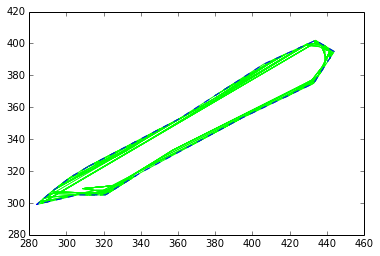

In [23]:
p,r=PR_compare(objid,unique_tiles,sampleNworkers=5)

In [111]:
# leftovers = bi
# for tidx,t in enumerate(tiles_tmp): #tiles cause topolgical error
#     leftovers = leftovers.difference(t)   
#     print leftovers

Intersect before: True
2864.80421431
Intersect after: True
1.62136593675e-13
44.2252198076
2839.51615882


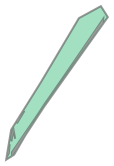

In [189]:
# leftovers = bi
# i=0
print "Intersect before:" , leftovers.intersects(tiles_tmp[i])
print leftovers.area
leftovers = leftovers.difference(tiles_tmp[i])   
print "Intersect after:" ,  leftovers.intersects(tiles_tmp[i])
print leftovers.intersection(tiles_tmp[i]).area
print tiles_tmp[i].area
print leftovers.area
i+=1


leftovers


In [ ]:
# plt.figure()
# if  type(leftovers)==shapely.geometry.MultiPolygon:
#     visualizeTilesSeparate(leftovers)
# else:
#     plot_coords(leftovers)
# plot_coords(t,color="#32cd32")